# [0] Imports

In [69]:
import Pkg;

using LinearAlgebra, Random, Gurobi, JuMP, Distributions, Plots, LazySets

using Dates

# [1] Setup

## [1.1] Parameters

In [70]:
n_jobs = 39
n_vehicles_jobs = n_jobs
n_vehicles_coverage = 10
T = 2 * n_jobs
min_duration = 2
max_duration = 6
speed = 1000/6
coverage_distance = 50
size = 500
step = 50;

## [1.2] Locations, Windows, Loads

In [71]:
Random.seed!(1234)

function create_cluster_sizes(jobs_total)
    Random.seed!(1234)
    jobs_created = 0
    cluster = []
    while jobs_created != jobs_total
        num_to_add = rand(min(3, jobs_total - jobs_created) : 
            min(Int((n_jobs/5)÷1), jobs_total - jobs_created))
        jobs_created += num_to_add
        push!(cluster, num_to_add)
    end
    
    return cluster
end;

In [72]:
time_windows = []
locations = rand(Uniform(0,size), 1, 2)
work_load = []
cluster = create_cluster_sizes(n_jobs);

In [73]:
function create_time_windows_and_work_load(cluster_sizes, locations)
    Random.seed!(1234)
    locations = rand(Uniform(0,size), 1, 2)
    for size_c in cluster
        first = rand(Uniform(0,size), 1, 2)
        locations = vcat(locations, first)

        job_begins = rand(2:10)
        job_finish = rand((job_begins+min_duration):(job_begins+max_duration))
        push!(time_windows, [job_begins, job_finish])

        time_work = rand(min_duration:max(min_duration, job_finish - job_begins))
        push!(work_load, time_work)

        for neighbour in 1:(size_c-1)
            new_x = rand(Uniform(max(0,first[1]-20), min(first[1]+20, size)), 1, 1)
            new_y = rand(Uniform(max(0,first[2]-20), min(first[2]+20, size)), 1, 1)
            new = hcat(new_x, new_y)
            locations = vcat(locations, new)

            job_begins = rand(job_finish:min(T-min_duration-2, job_finish + 6))
            job_finish = rand((job_begins+min_duration):(min(job_begins+max_duration, T-2)))
            push!(time_windows, [job_begins, job_finish])

            time_work = rand(min_duration:min(max_duration, job_finish-job_begins))
            push!(work_load, time_work)
        end
    end
    
    return [time_windows, work_load, locations]
end;

In [74]:
time_windows, work_load, locations = create_time_windows_and_work_load(cluster, locations)
distances = [LinearAlgebra.norm(locations[i, :] .- locations[j, :]) for i=1:n_jobs+1, j = 1:n_jobs+1];

# [2] Helper Methods

## 2.1 Get initial routes

In [75]:
routes = []

for n in 1:n_jobs
    job_route = []
    dist = distances[1, n+1]

    min_t = Int(floor(time_windows[n][1] - dist/speed))
    max_t = Int(ceil(time_windows[n][2] + dist/speed))

    push!(job_route, [[0, min_t], [n, time_windows[n][1]], dist])
    
    for t in time_windows[n][1]:(time_windows[n][2]-1)
        push!(job_route, [[n, t], [n, t+1], 0])
    end
    
    push!(job_route, [[n, time_windows[n][2]], [n_jobs+1, max_t],  dist])
    push!(routes, job_route)
    
end

## 2.2 Compute Cost

In [76]:
function compute_cost(route)
    cost = 0
    for entity in route
        cost += entity[3]
    end
    return cost
end;

In [77]:
C = []
for i in 1:length(routes)
    push!(C, compute_cost(routes[i]))
end

## 2.3 Compute Delta

In [78]:
function compute_delta(routes)
    Q = length(routes)
    delta = [[[0.0 for q in 1:Q] for t in 1:T] for i in 1:n_jobs]
    for rindex in 1:Q
        route = routes[rindex]
        for arc in route
            loc1, time1 = arc[1]
            loc2, time2 = arc[2]
            if (loc1 != 0) & (loc1 != n_jobs + 1)
                delta[loc1][time1][rindex] = 1
            end
            
            if (loc2 != 0) & (loc2 != n_jobs + 1)
                delta[loc2][time2][rindex] = 1
            end
        end
    end
    return delta
end;

In [79]:
delta = compute_delta(routes);

## 2.4 Compute U

In [80]:
function compute_u(routes)
    Q = length(routes)
    u = [[0 for q in 1:Q] for i in 1:n_jobs]
    
    for rindex in 1:Q
        route = routes[rindex]
        for arc in route
            loc1 = arc[1][1]
            loc2 = arc[2][1]
            if (1 <= loc1 <= n_jobs)
                u[loc1][rindex] = 1
            end
            if (1 <= loc2 <= n_jobs)
                u[loc2][rindex] = 1
            end
        end
    end
    return u
end;

In [81]:
u = compute_u(routes);

## 2.5 Label-Setting Algorithm

We've built this LSA to include multiple time-checking components. There are 3 places to check: 

1. The initial check for incrementing the current state
2. Feasibility check
3. Push new state if ...

Our goal is to figure out which of these steps consumes time.

In [82]:
function sp_lsa(n, travel_distance, travel_time, windows, load, rho_v, pi_v, mu_v, cool_stuff=false)
    N = [[1]] 
    Times = [ [0] ] 
    R = [rho_v]  
    L = [1]  
    
    time_total_start = datetime2unix(now())
    time_check_start = []
    time_check_end = []
    time_feas_start = []
    time_feas_end = []
    time_add_start = []
    time_add_end = []
    
    time_check = []
    
    #= Two parameters which are good if you're visualizing
    how quickly the number if iterations catches up
    to the total number of routes generated
    =#
    current_states = []
    total_states = []
    
    current_state = 1
    total_state = 1
    
    while 1==1
        
        # STEP 1: Check whether we want to move on to checking the next path
        push!(time_check_start, datetime2unix(now()))
        if (L[current_state] == n+2)
            current_state += 1
            if current_state > total_state
                push!(time_check_end, datetime2unix(now()))
                break
            else
                push!(time_check_end, datetime2unix(now()))
                continue
            end
        end
        push!(time_check_end, datetime2unix(now()))
        
        # STEP 2: Enter the for loop.
        for i in 2:(n+2)
            
            if cool_stuff
                push!(current_states, current_state)
                push!(total_states, total_state)
            end
            
            # STEP 2-1: Check that the current node is not already inside our path.
            if ~(i in N[current_state])
                
                #= STEP 2-2: Feasibility check. We must have enough time
                to go from our current location (end time T[current_state]), plus
                the travel time from that end node to the new node (travel_time[L[current_state], i]),
                plus the amount of time it takes to work the OLD job (load[L[current_state]-1]),
                plus the amount of time it takes to work the NEW job (load[i-1])
                
                this must be smaller than or equal to the end time of the window for the NEW job (windows[i-1][2])
                =#
                push!(time_feas_start, datetime2unix(now()))
                if L[current_state] != 1
                    cur_time = last(Times[current_state])
                    dist_nec = travel_time[L[current_state], i]
                    old_job_time_nec = load[L[current_state]-1] #out of our parameters this one has no depot pad
                    new_job_time_nec = load[i-1]
                    new_window_close = windows[i-1][2]
                    
                    #if invalid, don't bother
                    if cur_time + dist_nec + old_job_time_nec + new_job_time_nec > new_window_close
                        push!(time_feas_end, datetime2unix(now()))
                        continue
                    end
                end
                push!(time_feas_end, datetime2unix(now()))
                
                # STEP 2-3: Add the path to our N.

                push!(time_add_start, datetime2unix(now()))
                # First, copy the original state so we can modify it
                push!(N, copy(N[current_state]))
                # Add this new, guaranteed-to-be-valid, node.
                push!(N[total_state+1], i)

                # Time is going to be when we GET to the final node.

                #= I argue that we also need to include a work load term into the 
                term bounded by current_time + necessary_travel_distance.

                This is because there's no point in going to an old place, not 
                doing any work, and then going away to some new place.

                So in reality the check becomes tripartite.
                =#
                cur_time = last(Times[current_state])
                dist_nec = travel_time[L[current_state], i]
                old_job_time = L[current_state] > 1 ? load[L[current_state]-1] : 0
                new_window_start = windows[i-1][1]
                new_times_array = copy(Times[current_state])
                push!(new_times_array, max(cur_time + dist_nec + old_job_time, new_window_start))
                push!(Times, new_times_array)

                # Cost.
                # ADD the segment distance.
                add_segdist = travel_distance[L[current_state], i]
                # SUBTRACT pi_i.
                subtract_pi = i < n+2 ? -pi_v[i-1] : 0
                # SUBTRACT mu_it.
                subtract_mu = i < n+2 ? -mu_v[i-1, last(last(Times))] : 0

                push!(R, R[current_state] + add_segdist + subtract_pi + subtract_mu)

                # Last node is updated.
                push!(L, i)
                
                total_state += 1
                
                push!(time_add_end, datetime2unix(now()))
        
            end
        end
        
        current_state += 1 # concluded iteration for that state in mind. Now next one
        
        #= It's possible that we've just caught up to the final total state, meaning we didn't generate
        anything and can stop here. =#
        if current_state == total_state
            # print(current_state, " ", total_state, " came from bottom")
            break
        end     
    end
    
    #= It is not actually necessary to return L. This was a helpful parameter which we
    embedded in order to aid computation. But if we needed to get L, we would just go to 
    the path of concern and extract last([path_of_concern]). =#
    push!(time_check, time_check_end .- time_check_start)
    push!(time_check, time_feas_end .- time_feas_start)
    push!(time_check, time_add_end .- time_add_start)
    time_total_end = datetime2unix(now())
    push!(time_check, time_total_end - time_total_start)
    return N, R, Times, time_check
end

sp_lsa (generic function with 2 methods)

### 2.5.1 Label-Setting Algorithm Constant Variables

In [83]:
distances_label = deepcopy(distances)
distances_label = hcat(distances_label, distances_label[:, 1])
distances_label = vcat(distances_label, collect(push!(distances_label[:, 1], 0)'));

In [84]:
travel_times = ceil.(distances_label / speed);

In [85]:
windows_label = deepcopy(time_windows)
push!(windows_label, [0, 100]);

In [86]:
load_label = deepcopy(work_load)
push!(load_label, 0);

## 2.6 Extract Best Route in SP

In [87]:
function extract_best_route(sub_paths, sub_rc, sub_times, n=1)
    
    #= Do a search to find the n best routes.
    The colgen appears to be unreliable in several instances
    so instead of finding the best route I give the machine
    several options. =#
    
    route_capsule = [] # each route will be: sub_path, sub_times, sub_rc
    
    for i in 1:length(sub_paths)
        if last(sub_paths[i]) == n_jobs + 2
            push!(route_capsule, [sub_paths[i], sub_times[i], sub_rc[i]])
        end
    end
    
    # now, sort by reduced cost
    sort!(route_capsule, lt = (x, y) -> isless(x[3], y[3]))
    
    # return the best n paths. Don't calculate reduced cost right now.
    return route_capsule[1:n]
end;

## 2.7 Generate full time info on route

In [88]:
function generate_full_time_info(best_route, best_times)
    best_route_info = []
    for locindex in 1:length(best_route)-1
        #=
        Strategy:
        If you are not at a job location, you don't need to capture
        stationary information. Otherwise you do.

        Anyways we want data moving from one to the next.
        =#
        cur_loc = best_route[locindex]
        cur_time = best_times[locindex]
        time_to_start_moving = best_times[locindex]

        #stationary data comes first.
        if 1 < locindex < n_jobs + 2
            cur_job_num = cur_loc - 1 # delete padding!

            #stay stationary for however long it takes for you to do the job

            # Note: eventually this will have to be modified to include coverage.
            # Eventually we will write a subproblem-tells-us-when-work-is-done component.

            for time in cur_time:cur_time+work_load[cur_job_num]-1
                route_detail = [ [cur_loc-1, time], [cur_loc-1, time+1], 0]
                push!(best_route_info, route_detail)
            end

            time_to_start_moving += work_load[cur_job_num]
        end

        new_loc = best_route[locindex+1]
        #then if we move, we move.
        route_detail = [ [cur_loc-1, time_to_start_moving], [new_loc-1, best_times[locindex+1]], distances_label[cur_loc, new_loc]]
        push!(best_route_info, route_detail)
    end

    return best_route_info
end;

# [3] Column Generation Loop

## [3.1] Initial Run

### [3.1.1] Run RMP

In [89]:
modelcg = Model(Gurobi.Optimizer);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04


In [90]:
Q = length(routes)

39

In [91]:
unregister(modelcg, :z)
unregister(modelcg, :y_s)
unregister(modelcg, :y_e)
@variable(modelcg, 0 <= z[1:Q] <= 1) # should be Bin
@variable(modelcg, 0 <= y_s[1:n_jobs, 1:T] <= 1) # should be Bin
@variable(modelcg, 0 <= y_e[1:n_jobs, 1:T] <= 1); # should be Bin

In [92]:
unregister(modelcg, :unique)
@constraint(modelcg, unique[i in 1:n_jobs], sum(u[i][q] * z[q] for q in 1:Q) >= 1);

In [93]:
unregister(modelcg, :driver)
@constraint(modelcg, driver, sum(z[q] for q in 1:Q) <= n_vehicles_jobs)

unregister(modelcg, :start)
unregister(modelcg, :ends)
@constraint(modelcg, start[i in 1:n_jobs, t in 1:(T-1)], y_s[i,t] <= y_s[i,t+1])
@constraint(modelcg, ends[i in 1:n_jobs, t in 1:(T-1)], y_e[i,t] <= y_e[i,t+1])
unregister(modelcg, :window_start)
unregister(modelcg, :window_ends)
@constraint(modelcg, window_start[i in 1:n_jobs, t in 1:(time_windows[i][1]-1)], y_s[i,t] == 0)
@constraint(modelcg, window_ends[i in 1:n_jobs, t in time_windows[i][2]:T], y_e[i,t] == 1)
unregister(modelcg, :duration)
@constraint(modelcg, duration[i in 1:n_jobs], sum(y_s[i,t] - y_e[i,t] for t in 1:T) >= work_load[i])
unregister(modelcg, :work)
@constraint(modelcg, work[i in 1:n_jobs, t in 1:(T-1)], 
    y_s[i, t] - y_e[i, t] <= sum(z[q] * delta[i][t][q] for q in 1:Q));

In [94]:
unregister(modelcg, :coverage)
@constraint(modelcg, coverage[i in 1:n_jobs, t in 1:T], y_s[i, t] - y_e[i, t] <= 1);

In [95]:
@objective(modelcg, Min, sum(compute_cost(routes[q]) * z[q] for q in 1:Q));

In [96]:
optimize!(modelcg)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 15004 rows, 6123 columns and 33345 nonzeros
Model fingerprint: 0xcca9cbfb
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 15004 rows and 6123 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6565115e+04   0.000000e+00   0.000000e+00      0s

Solved with dual simplex
Solved in 0 iterations and 0.02 seconds (0.01 work units)
Optimal objective  1.656511514e+04

User-callback calls 183, time in user-callback 0.00 sec


### [3.1.2] Get Dual Variables

In [97]:
pi_values = dual.(unique)
rho_value = dual.(driver)
mu_values = dual.(work);

### [3.1.3] Time Analysis (Use Subproblem LSA)

In [98]:
time_1 = datetime2unix(now())
sub_paths, sub_rc, sub_times, tanal = sp_lsa(n_jobs, distances_label, travel_times, windows_label, load_label, rho_value, pi_values, mu_values);
time_2 = datetime2unix(now());

This is the time the algorithm took in total.

In [99]:
time_2-time_1

23.507999897003174

In [100]:
tanal[4]

23.317000150680542

Now let's see how many times we passed through each check.

In [101]:
for i in 1:3
    println(length(tanal[i]))
end

1685280
27715760
1685279


Checking the first place: see if we increment current state. (I have the plot on mute because it takes too much space and slows down the entire notebook!)

In [102]:
plot([i for i in 1:length(tanal[1])], tanal[1], seriestype=:line, legend=:topright, size = (350, 300));

In [103]:
sum(tanal[1])

0.4389982223510742

In [104]:
count = 0
for elt in tanal[1]
    if elt > 1e-4
        count += 1
    end
end

In [105]:
count / length(tanal[1])

0.0002569305990695908

Checking the second place: feasibility check.

Julia refuses to get me the graph because we have to plot 13 million points.

In [106]:
plot([i for i in 1:length(tanal[2])], tanal[2], seriestype=:line, legend=:topright, size = (600, 300));

In [107]:
sum(tanal[2])

9.407002449035645

In [108]:
count = 0
for elt in tanal[2]
    if elt > 1e-4
        count += 1
    end
end

In [109]:
count / length(tanal[2])

0.00033266271608644324

In [110]:
count

9220

Checking the third: push data.

In [111]:
sum(tanal[3])

4.104994058609009

In [112]:
# there's an outlier of 0.4 seconds and one of 0.01 seconds
data = []
for i in 1:length(tanal[3])
    if 0 <= tanal[3][i] <= 0.009
        push!(data, tanal[3][i])
    end
end

In [125]:
plot([i for i in 1:length(data)], data, seriestype=:line, legend=:topright, size = (350, 300));

In [119]:
bin_size = 10000
density = []
for thousand in 1:Int(floor(length(tanal[3]) / bin_size))
    count = 0
    for i in 1:1000
        if tanal[3][(thousand-1) * bin_size + i] > 1e-5
            count += 1
        end
    end
    push!(density, count)
end

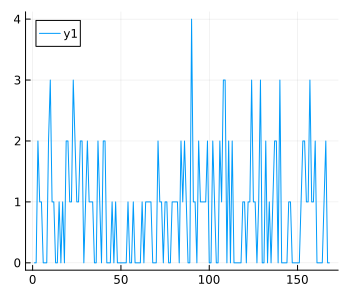

In [120]:
plot([i for i in 1:length(density)], density, seriestype=:line, legend=:topleft, size=(350, 300))

In [121]:
cumsum = []
total = 0
for i in 1:length(tanal[3])
    total += tanal[3][i]
    push!(cumsum, total)
end

In [167]:
plot([i for i in 1:length(cumsum)], cumsum, seriestype=:line, legend=:topleft, size=(350, 300));

# this file is literally 53.2 mb large so I've hidden it

In [127]:
newsum = []
total = 0
for i in 1:length(data)
    total += data[i]
    push!(newsum, total)
end

In [168]:
plot([i for i in 1:length(newsum)], newsum, seriestype=:line, legend=:topleft, size=(350, 300));
# this file is literally 50mb so I've hidden it

# [4] The Playground

Let's test some things out so we know how efficient Julia operations will be in the long run.

In [150]:
time_start = datetime2unix(now())
k = [1]
for i in 1:1e7
    push!(k, i)
end
time_end = datetime2unix(now())

println(time_end - time_start)

0.35000014305114746


In [144]:
time_start = datetime2unix(now())
large = 10000000
k = [i for i in 1:large]
l = []
for i in 1:large
    push!(l, k[i])
end
time_end = datetime2unix(now())

println(time_end - time_start)

1.4789998531341553


In [149]:
time_start = datetime2unix(now())
large = 10000000
k = [i for i in 1:large]
l = []
for i in 1:large
    last(k);
end
time_end = datetime2unix(now())

println(time_end - time_start)

0.9820001125335693


In [162]:
time_start = datetime2unix(now())
large = 100000000
k = [i for i in 1:large]
for i in 1:large
    last(k);
end
time_end = datetime2unix(now())

println(time_end - time_start)

8.655999898910522


In [163]:
time_start = datetime2unix(now())
large = 100000000
k = [i for i in 1:large]
a = last(k)
for i in 1:large
    a;
end
time_end = datetime2unix(now())

println(time_end - time_start)

6.63100004196167
